<a href="https://colab.research.google.com/github/sispo3314/AI_study/blob/main/HAR/UCI_HAR_cbam%2Btransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [325]:
import os
import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import keras

In [326]:
#라벨 정리
ACTIVITIES={
    0:'WALKING',
    1:'WALKING_UPSTAIRS',
    2:'WALKING_DOWNSTAIRS',
    3:'SITTING',
    4:'STANDING',
    5:'LAYING'
}

In [327]:
#혼돈행렬 함수
def confustion_matrix(Y_true, Y_pred):
  Y_true=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
  Y_pred=pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

  return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [328]:
DATADIR= os.path.join(os.getcwd(), 'drive','MyDrive','datasets')

SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"]

In [329]:
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename= DATADIR + f'/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)

    return np.transpose(signals_data, (1, 2, 0))

In [330]:
def load_y(subset):
    filename= DATADIR + f'/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = pd.read_csv(filename, delim_whitespace=True, header=None)[0]
    return pd.get_dummies(y).values

In [331]:
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, y_train, X_test,  y_test

In [332]:
np.random.seed(36)
rn.seed(36)
tf.random.set_seed(36)

In [333]:
#라벨 개수 세기
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [334]:
#전에 정리한 데이터셋 불러오기
X_train, Y_train, X_val, Y_val= load_signals('train'), load_y('train'), load_signals('test'), load_y('test')

/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd.read_csv(filename, delim_whitespace=True, header=None).values)
/tmp/ipython-input-1131027008.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  signals_data.append(pd

In [335]:
class scaling_tseries_data(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scale = None
    def fit(self, X, y=None):
        Xf = X.reshape(-1, X.shape[-1])
        self.scale = StandardScaler().fit(Xf)
        return self
    def transform(self, X):
        Xf = X.reshape(-1, X.shape[-1])
        Xf = self.scale.transform(Xf)
        return Xf.reshape(X.shape)

Scale = scaling_tseries_data().fit(X_train)
X_train_sc = Scale.transform(X_train)
X_val_sc   = Scale.transform(X_val)

### CBAM+transformer encoder

In [336]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D,
    BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention,
    Add, Layer, Embedding, Activation, Multiply, Concatenate, Reshape, Lambda
)
from tensorflow.keras.models import Model

In [337]:
from tensorflow.keras import backend as K
def channel_attention(inputs, ratio=8):
  #K.int_shape: 입력받은 텐서(tensor)의 shape를 파이썬 정수 튜플로 반환
  channels=K.int_shape(inputs)[-1] #반환된 튜플의 마지막 요소 (channels)가져오기
  #MLP 공유
  shared_layer_one=Dense(channels//ratio, activation='relu',
                         kernel_initializer='he_normal', use_bias=True)
  shared_layer_two=Dense(channels, kernel_initializer='he_normal', use_bias=True)

  #Global Average Pooling
  avg_pool=GlobalAveragePooling1D()(inputs) #(batch, channels)
  avg_pool=shared_layer_one(avg_pool)
  avg_pool=shared_layer_two(avg_pool)

  #Global Max Pooling
  max_pool=GlobalMaxPooling1D()(inputs) #(batch, channels)
  max_pool=shared_layer_one(max_pool)
  max_pool=shared_layer_two(max_pool)

  attention=Add()([avg_pool, max_pool])
  attention=Activation('sigmoid')(attention)

  #Reshape
  attention=Reshape((1, channels))(attention)
  return Multiply()([inputs, attention])


In [338]:

def spatial_attention(inputs, kernel_size=7):
  #채널 축 압축 (각 seq_len(시간)마다 존재하는 여러 채널의 정보를 하나의 대표값으로 요약)
  #inputs: 연산을 적용할 대상 텐서, axis=2: 압축할 차원의 번호(=channels), keepdims=True: 차원을 유지하라.)
  avg_pool=Lambda(lambda x: tf.reduce_mean(x, axis=2, keepdims=True))(inputs) # (batch, seq_len, 1)
  max_pool=Lambda(lambda x: tf.reduce_max(x, axis=2, keepdims=True))(inputs) # (batch, seq_len, 1)

  #요약 정보 합치기
  concat=Concatenate(axis=2)([avg_pool, max_pool]) # (batch, seq_len, 2)

  #1D 컨볼루션 적용(중요도 점수 계산)
  #sigmoid 활성함수를 사용하여 0과 1 사이의 점수로 변환
  attention=Conv1D(1,
                   kernel_size, padding='same',
                   activation='sigmoid', kernel_initializer='he_normal',
                   use_bias=False)(concat) #(batch, seq_len, 1)
  #원본 입력에 중요도 점수맵 곱하기
  return Multiply()([inputs, attention])

In [339]:
#CBAM 블록
def cbam_block(inputs, ratio=8, kernel_size=7):
  cbam_feature=channel_attention(inputs, ratio)
  cbam_feature=spatial_attention(cbam_feature, kernel_size)
  return cbam_feature

In [340]:
from tensorflow.keras.layers import Embedding, Layer

class PositionalEmbedding(Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.pos_emb = Embedding(input_dim=seq_len, output_dim=d_model)
        self.seq_len = seq_len

    def call(self, x):
        positions = tf.range(start=0, limit=self.seq_len, delta=1)
        embedded_positions = self.pos_emb(positions)
        return x + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            'seq_len': self.seq_len,
            'd_model': self.d_model,
        })
        return config

In [341]:
def transformer_encoder_block(inputs, d_model, num_heads, ff_dim, dropout=0.1):
  #멀티헤드 어텐션
  attn_input=LayerNormalization(epsilon=1e-6)(inputs)
  attention=MultiHeadAttention(
      num_heads=num_heads, key_dim=d_model//num_heads
  )(attn_input, attn_input)
  attention=Dropout(dropout)(attention)
  attn_output=Add()([inputs, attention])

  #피드포워드 네트워크
  ffn_input=LayerNormalization(epsilon=1e-6)(attn_output)
  ffn_output=Dense(ff_dim, activation="relu")(ffn_input)
  ffn_output=Dropout(dropout)(ffn_output)
  ffn_output=Dense(d_model)(ffn_output)

  return Add()([attn_output, ffn_output])

In [342]:
from tensorflow.keras import regularizers
def build_cbam_transformer(input_shape, num_classes, d_model=64, num_heads=4, ff_dim=128, num_transformer_blocks=2):
    l2_reg = regularizers.l2(1e-4)
    inputs = Input(shape=input_shape)

    # === CNN Block 1 + CBAM ===
    x = Conv1D(filters=64, kernel_size=7, padding='same', kernel_regularizer=l2_reg)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = cbam_block(x, ratio=8)
    x = MaxPooling1D(pool_size=2)(x)

    # === CNN Block 2 + CBAM ===
    x = Conv1D(filters=d_model, kernel_size=5, padding='same', kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x, ratio=8)
    x = MaxPooling1D(pool_size=2)(x) # (32, 64)

    # === CNN Block 3 ===
    x = Conv1D(filters=d_model, kernel_size=3, padding='same', kernel_regularizer=l2_reg)(x) # *** 새로운 층 ***
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x, ratio=8)
    x = MaxPooling1D(pool_size=2)(x)

    # CNN 출력 시퀀스 길이
    seq_len_cnn = x.shape[1]

    #Transformer Encoder
    x = PositionalEmbedding(seq_len=seq_len_cnn, d_model=d_model)(x)
    x = Dropout(0.2)(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder_block(x, d_model, num_heads, ff_dim, dropout=0.3)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu',kernel_regularizer=l2_reg)(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [343]:
INPUT_SHAPE = (X_train_sc.shape[1], X_train_sc.shape[2])
NUM_CLASSES = Y_train.shape[1]


cbam_model = build_cbam_transformer(
    INPUT_SHAPE,
    num_classes=NUM_CLASSES,
    d_model=128,
    num_heads=4,
    ff_dim=256,
    num_transformer_blocks=2
)

import tensorflow as tf
from tensorflow import keras

cbam_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.F1Score(average='macro', name='f1_macro')
    ]
)

cbam_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_91 (Conv1D)  │ (None, 128, 64)   │      4,096 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 64)   │        256 │ conv1d_91[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_92       │ (None, 128, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ activation_92[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ activation_92[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_204 (Dense)   │ (None, 8)         │        520 │ global_average_p… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_205 (Dense)   │ (None, 64)        │        576 │ dense_204[0][0],  │
│                     │                   │            │ dense_204[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_121 (Add)       │ (None, 64)        │          0 │ dense_205[0][0],  │
│                     │                   │            │ dense_205[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_93       │ (None, 64)        │          0 │ add_121[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_45          │ (None, 1, 64)     │          0 │ activation_93[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_89         │ (None, 128, 64)   │          0 │ activation_92[0]… │
│ (Multiply)          │                   │            │ reshape_45[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_88 (Lambda)  │ (None, 128, 1)    │          0 │ multiply_89[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_89 (Lambda)  │ (None, 128, 1)    │          0 │ multiply_89[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_44      │ (None, 128, 2)    │          0 │ lambda_88[0][0],  │
│ (Concatenate)       │                   │            │ lambda_89[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_92 (Conv1D)  │ (None, 128, 1)    │         14 │ concatenate_44[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_90         │ (None, 128, 64)   │          0 │ multiply_89[0][0… │
│ (Multiply)          │                   │            │ conv1d_92[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 64, 64)    │          0 │ multiply_90[0][0] │
│ (MaxPooling1D)      │                   │            │                 

 Total params: 389,656 (1.49 MB)

 Trainable params: 389,016 (1.48 MB)

 Non-trainable params: 640 (2.50 KB)

In [344]:
import tensorflow as tf
tf.keras.utils.plot_model(cbam_model, show_shapes=True)

In [345]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# F1 점수를 기준으로 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_f1_macro',
    mode='max',
    patience=20,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_macro',
    mode='max',
    factor=0.2,
    patience=10,
    min_lr=1e-6
)

In [346]:
counts = Y_train.sum(axis=0)
class_weight = {i: float(counts.max()/c) for i, c in enumerate(counts)}

history = cbam_model.fit(
    X_train_sc,
    Y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_sc, Y_val),
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weight,
    verbose=1
)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.7502 - f1_macro: 0.7465 - loss: 0.7817 - val_accuracy: 0.6990 - val_f1_macro: 0.7094 - val_loss: 1.3957 - learning_rate: 5.0000e-04
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9383 - f1_macro: 0.9411 - loss: 0.2157 - val_accuracy: 0.8884 - val_f1_macro: 0.8896 - val_loss: 0.5132 - learning_rate: 5.0000e-04
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9403 - f1_macro: 0.9433 - loss: 0.1990 - val_accuracy: 0.9091 - val_f1_macro: 0.9095 - val_loss: 0.4342 - learning_rate: 5.0000e-04
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9483 - f1_macro: 0.9512 - loss: 0.1742 - val_accuracy: 0.9097 - val_f1_macro: 0.9103 - val_loss: 0.3897 - learning_rate: 5.0000e-04
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9516 - f1_macro: 0.9544 - loss: 0.1780 - val_accuracy: 0.9087 - val_f1_macro: 0.9087 - val_loss: 0.4468 - learning_rate: 5.0000e-04
Epoch 6

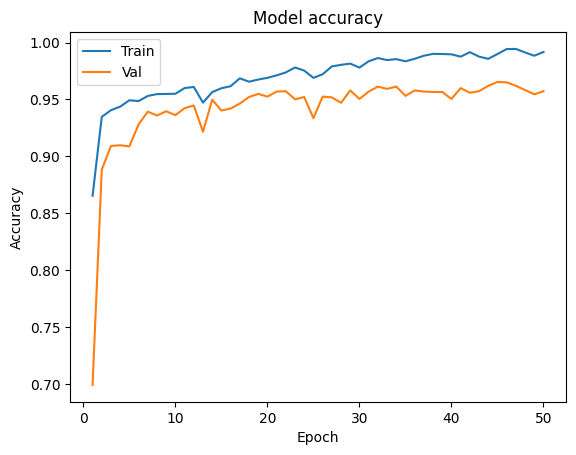

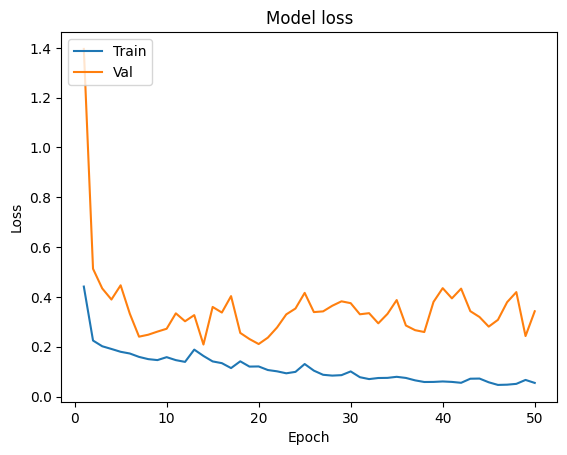

In [347]:
import matplotlib.pyplot as plt
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epochs_run = len(history.history['loss'])
  epoch_range = range(1, epochs_run+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 50)

In [348]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Y_pred = cbam_model.predict(X_val_sc)
y_true_indices = np.argmax(Y_val, axis=1)
y_pred_indices = np.argmax(Y_pred, axis=1)
target_names = list(ACTIVITIES.values())

print("\n--- Classification Report ---")
print(classification_report(y_true_indices, y_pred_indices, target_names=target_names))

93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step

--- Classification Report ---
                    precision    recall  f1-score   support

           WALKING       0.98      0.99      0.99       496
  WALKING_UPSTAIRS       0.99      0.98      0.98       471
WALKING_DOWNSTAIRS       1.00      1.00      1.00       420
           SITTING       0.96      0.85      0.90       491
          STANDING       0.89      0.98      0.93       532
            LAYING       0.99      1.00      0.99       537

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947




--- Confusion Matrix ---


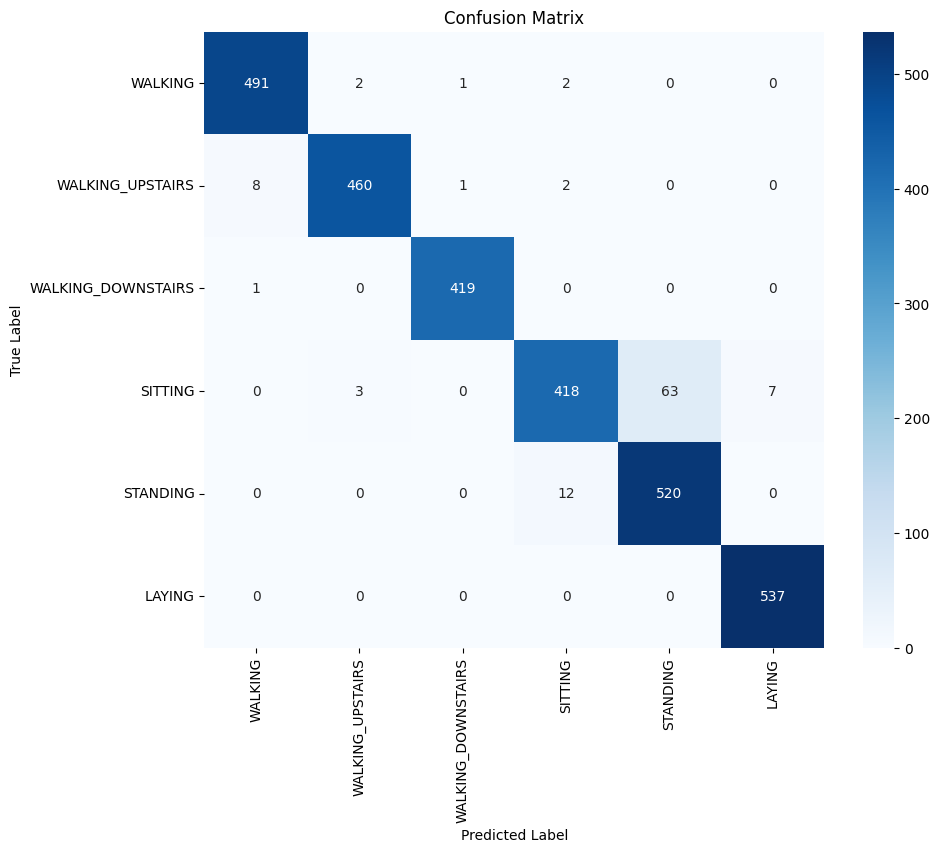

In [349]:
import matplotlib.pyplot as plt
import seaborn as sns

def confustion_matrix(Y_true, Y_pred):
    labels = list(ACTIVITIES.values())
    true_labels = pd.Series(
        [ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)],
        name='True'
    )
    true_labels = pd.Categorical(true_labels, categories=labels)
    pred_labels = pd.Series(
        [ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)],
        name='Pred'
    )

    pred_labels = pd.Categorical(pred_labels, categories=labels)
    return pd.crosstab(true_labels, pred_labels, dropna=False)

print("\n--- Confusion Matrix ---")
cm_df = confustion_matrix(Y_val, Y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_df.columns,
            yticklabels=cm_df.index)

plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()